# Reconstruction Analysis True Hits (RATH) : Analysis 
- Analysis of the output of the Reconstruction Analysis for True hits (RATH).
- Loads from disk
- Plot Statistics
- GraphTracks manipulation
    - GraphTracks are constructed from the EventTrack object, and are used to define blobs and find blob energy. 
- Visualisation of events where single and multiple tracks where reconstructed in $\beta\beta0\nu$ events.

##### General

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
import functools
import time

from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [4]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

##### IC

In [7]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


##### TICs

In [8]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.pd_tics   import slice_and_select_df
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

##### NetFlex

In [9]:
from nextflex.core import Setup

In [10]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [11]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import GTracks
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy


In [12]:
from nextflex.io import write_event_gtracks_json
from nextflex.io import load_event_gtracks_json
from nextflex.io import save_to_JSON
from nextflex.io import load_from_JSON

In [13]:
from nextflex.reco_analysis import reco_gtrack_from_mc_hits
from nextflex.reco_analysis import reco_gtrack_blobs
from nextflex.reco_analysis import TrackRecoStats
from nextflex.reco_analysis import TrackRecoTiming
from nextflex.reco_analysis import TrackRecoEventStats
from nextflex.reco_analysis import GtrkStats
from nextflex.reco_analysis import gtrack_summary
from nextflex.reco_analysis import select_gtrack_topology
from nextflex.reco_analysis import distance_between_extrema
from nextflex.reco_analysis import gtrack_df
from nextflex.reco_analysis import event_list_by_multiplicity
from nextflex.reco_analysis import tExtrema_df
from nextflex.reco_analysis import RecoGtrackFromMcHits

In [14]:
from nextflex.analysis_histos import reco_gtrack_stats_histos
from nextflex.analysis_histos import reco_gtrack_timing_histos
from nextflex.analysis_histos import reco_gtrack_blobs_histos
from nextflex.analysis_graphics import plot_single_tracks_list
from nextflex.analysis_graphics import plot_multiple_tracks_list

In [15]:
from nextflex.types import EventHits
from nextflex.types import VoxelHits


In [169]:
from nextflex.analysis_blobs import blob_energy
from nextflex.analysis_blobs import select_topology_and_energy
from nextflex.analysis_blobs import select_blobs_eff_energy
from nextflex.analysis_blobs import select_blobs
from nextflex.analysis_blobs import energy_resolution
from nextflex.analysis_blobs import selection_efficiency

## Input data

In [16]:
FDATA = os.environ['FLEXDATA']

##### bb0nu

In [17]:
setbb = Setup(flexDATA = FDATA,
              sipmPDE  = 1.0,
              maskPDE  = 1.0,
              qTh      = 0.0,
              tpConfig = "FLEX100_M6_O6_EL8bar_bb0nu")
print(setbb)


        Setup <FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6_EL8bar_bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu
        number of h5 files in dir    = 206
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.cs

##### single electrons

In [18]:
set1e = Setup(flexDATA = FDATA,
              sipmPDE  = 1.0,
              maskPDE  = 1.0,
              qTh      = 0.0,
              tpConfig = "FLEX100_M6_O6.EL8bar")
print(set1e)


        Setup <FLEX100_M6_O6.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6.EL8bar
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6.EL8bar
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6.EL8bar
        number of h5 files in dir    = 412
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6.EL8bar_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.csv
        


## Local code

##### Complexity scatter plot

In [19]:
def plot_complexity(rbb, r1e, figsize=(14,7)):
    def plt_scatter(rb, label):
        plt.title (f"Reconstruction time versus complexity ({label})")
        plt.scatter(rb.tVoxelizationXYZ.xyz_bins, rb.tVoxelizationXYZ.time, marker='o')
        plt.xlabel(r"$x_{bins} \times y_{bins} \times z_{bins} / 10^6$")
        plt.ylabel("time (seconds)")
        
    fig = plt.figure(figsize=figsize)
    ax      = fig.add_subplot(1, 2, 1)
    plt_scatter(rbb, "bbonu")
    ax      = fig.add_subplot(1, 2, 2)
    plt_scatter(r1e, "1e")
    plt.tight_layout()
    plt.show()

## Analysis

In [21]:
voxel_bin  = 5.
contiguity = 10

### Create a new instance and load from disk

##### bb0nnu

In [22]:
rbb = RecoGtrackFromMcHits(setbb, voxel_bin, contiguity)

In [23]:
rbb.load_setup()

##### 1e 

In [24]:
r1e = RecoGtrackFromMcHits(set1e, voxel_bin, contiguity)

In [25]:
r1e.load_setup()

### Statistics

#### Reco Event Statistics

##### bb

In [26]:
rbb.trackRecoEventStats


        <Track Reconstruction Statistics>
        size of voxel bins          = 5.0
        contiguity parameter        = 10
        topology                    = all
        event type                  = bb0nu
        voxels from hits barycenter = True
        number of files analyzed    = 205
        number of events analyized  = 815
        number of events 1 GT       = 537
        

##### 1e

In [27]:
r1e.trackRecoEventStats


        <Track Reconstruction Statistics>
        size of voxel bins          = 5.0
        contiguity parameter        = 10
        topology                    = all
        event type                  = 1e
        voxels from hits barycenter = True
        number of files analyzed    = 411
        number of events analyized  = 1489
        number of events 1 GT       = 975
        

In [157]:
total_events_bb = rbb.trackRecoEventStats.e_total
total_events_1e = r1e.trackRecoEventStats.e_total
print(f"total events bb = {total_events_bb}, total events 1e = {total_events_1e}")

total events bb = 815, total events 1e = 1489


#### Complexity

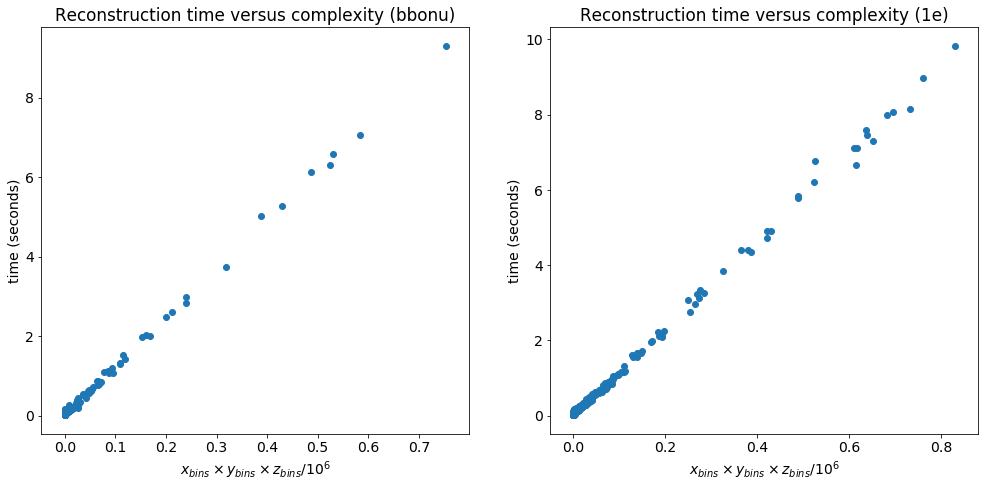

In [28]:
plot_complexity(rbb, r1e, figsize=(14,7))

#### Reco GTracks

##### bb0nu

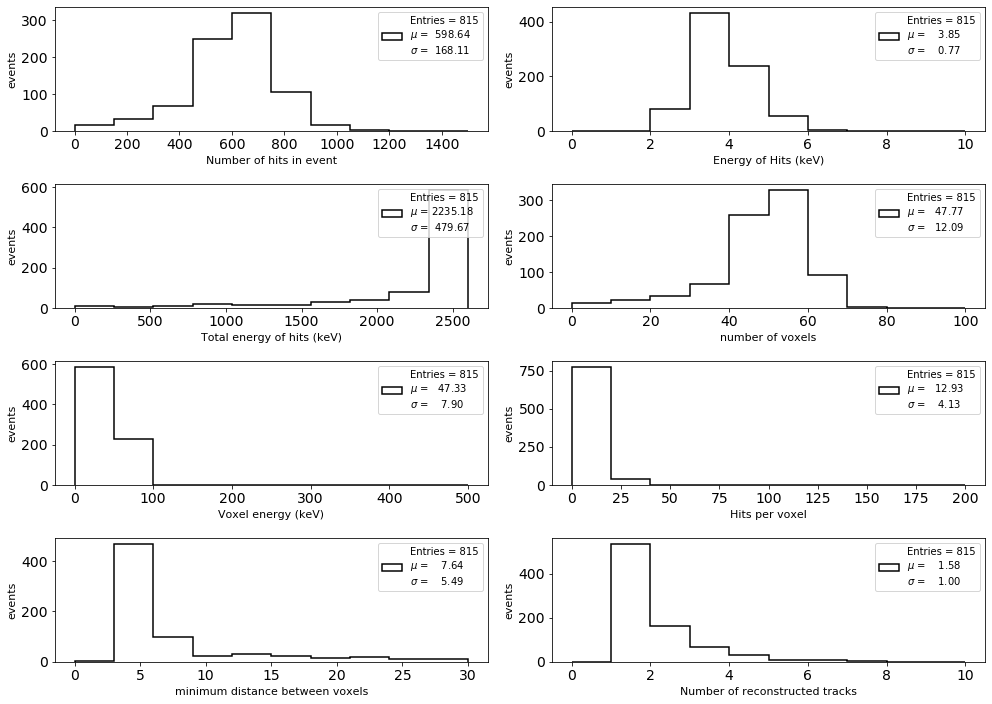

In [29]:
reco_gtrack_stats_histos(rbb.trackRecoStats, energy_evt_hits = (0,10),  min_dist_voxels = (0,30),figsize=(14,10))

##### 1e

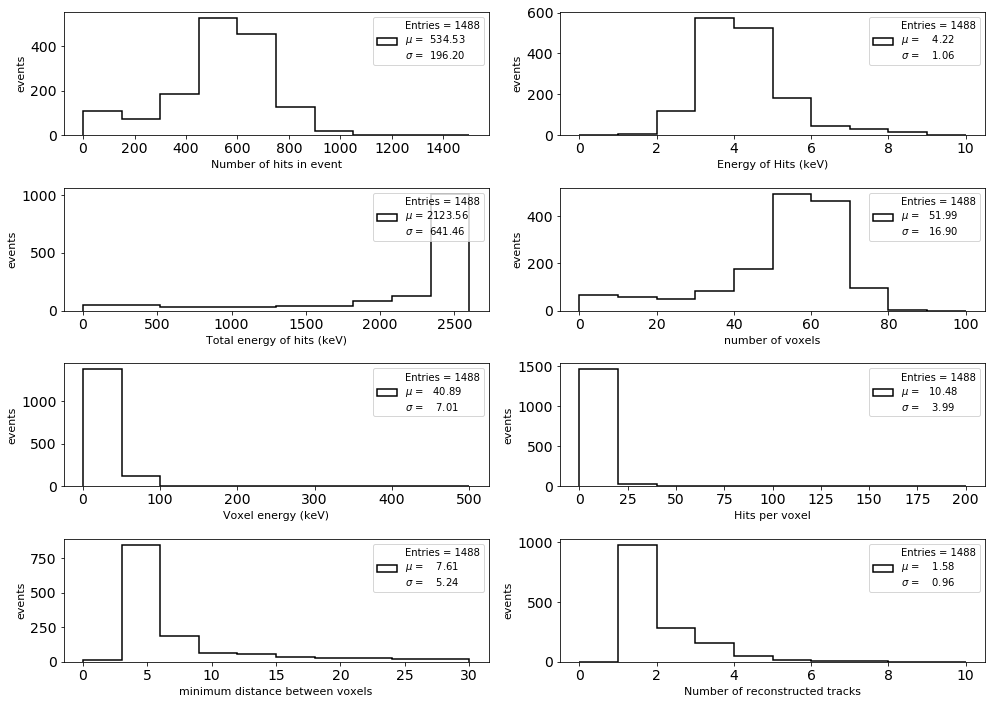

In [30]:
reco_gtrack_stats_histos(r1e.trackRecoStats, energy_evt_hits = (0,10),  min_dist_voxels = (0,30),figsize=(14,10))

- Notice that the number of reconstructed tracks in bb0nu and single electrons have the same distributions (in fact all distributions are very similar) which shows that selecting more than one track does not help (increases signal and background in the same proportion)

#### Timing

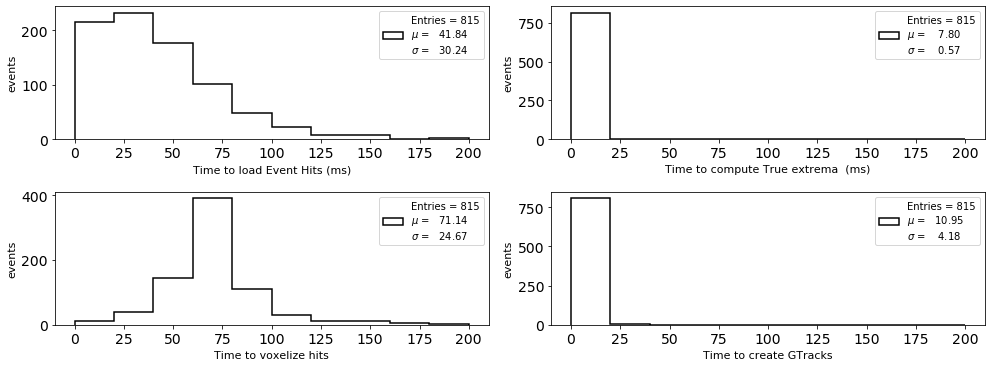

In [31]:
reco_gtrack_timing_histos(rbb.trackRecoTiming, figsize=(14,10))

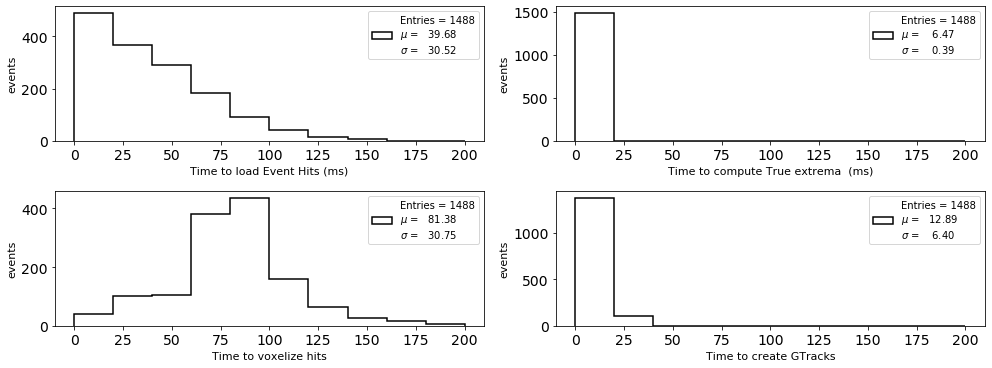

In [32]:
reco_gtrack_timing_histos(r1e.trackRecoTiming, figsize=(14,10))

Reconstructing single electrons takes a bit longer (81 ms vs 71 ms) than reconstructing bb0nu which suggests that electron tracks may be a bit longer (less convoluted than bb0nu double electrons)

### Graph Tracks and True Extrema

- The radius of the blob is taken as having the same size of the voxelisation. This is a parameter which can be varied for optimisation

In [174]:
rb = 5

#### bb0nu

##### bb0nu

In [175]:
gtbb = gtrack_df(rbb.gtracks, rb)

##### Select the topology of single tracks

In [177]:
g1tbb = select_gtrack_topology(gtbb, topology = "single")

In [178]:
print(f"efficiency, single track topology = {len(g1tbb) / total_events_bb}")

efficiency, single track topology = 0.6588957055214724


##### Histograms for single track topology

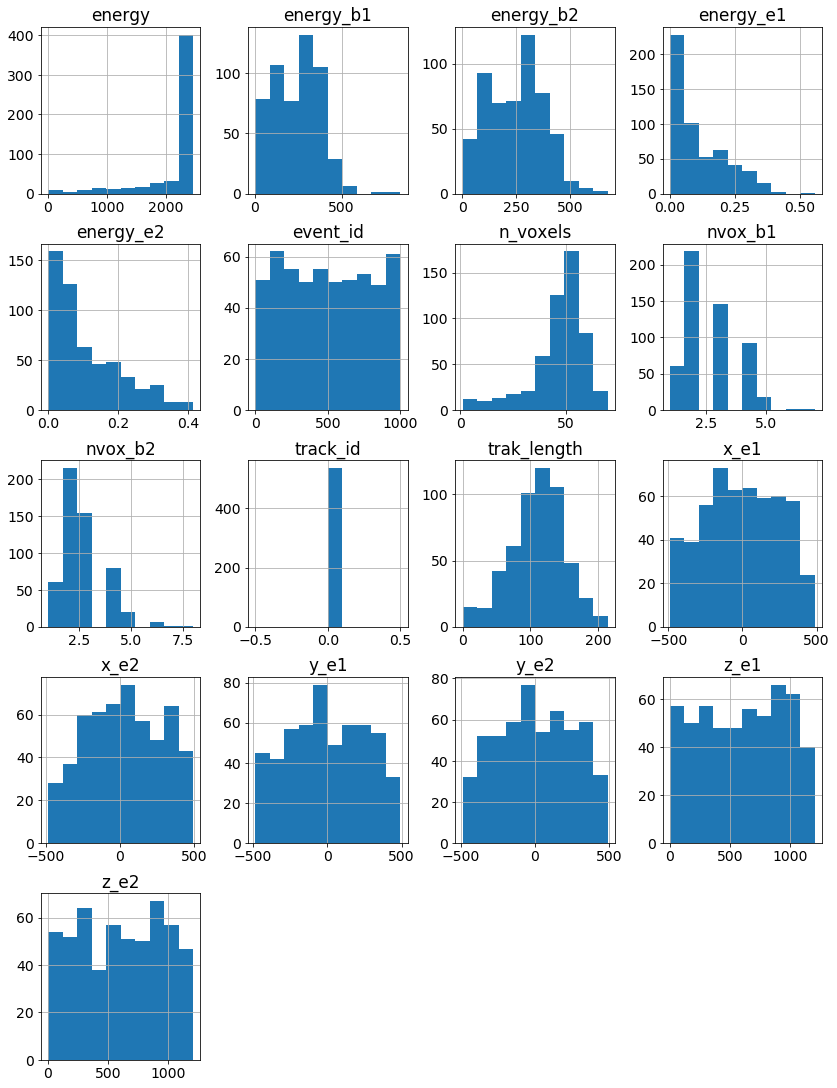

In [179]:
hist = g1tbb.hist(figsize = (14,19))

##### Energy blob1 vs blob2

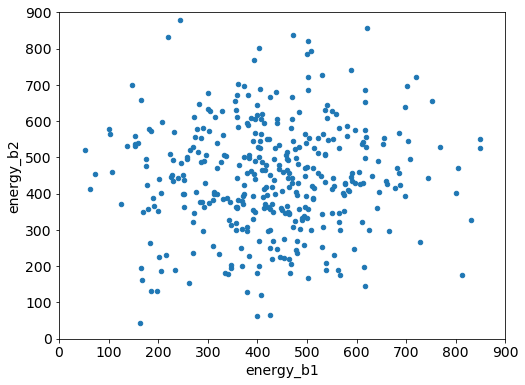

In [180]:
ax1 = e1tbb.plot.scatter(x='energy_b1', y='energy_b2')
ax1.set_xlim([0,900])
ax1.set_ylim([0,900])
plt.show()

#### 1e

In [181]:
gt1e = gtrack_df(r1e.gtracks, rb)

In [182]:
g1t1e = select_gtrack_topology(gt1e, topology = "single")

In [183]:
print(f"efficiency, single track topology = {len(g1t1e) / total_events_1e}")

efficiency, single track topology = 0.6548018804566823


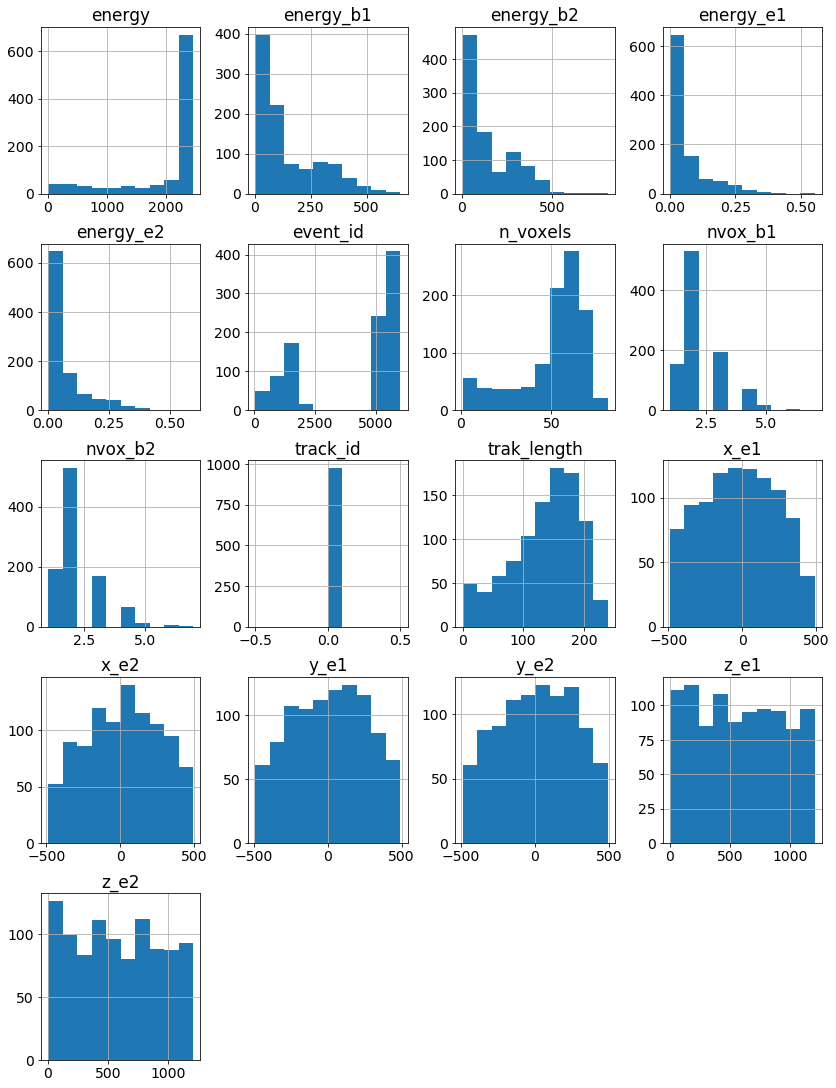

In [184]:
hist = g1t1e.hist(figsize = (14,19))

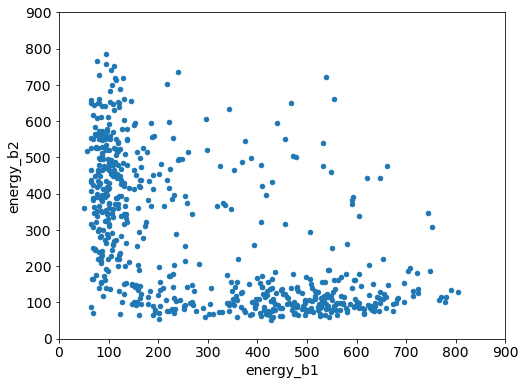

In [185]:
ax1 = e1t1e.plot.scatter(x='energy_b1', y='energy_b2')
ax1.set_xlim([0,900])
ax1.set_ylim([0,900])
plt.show()

### Blob analysis

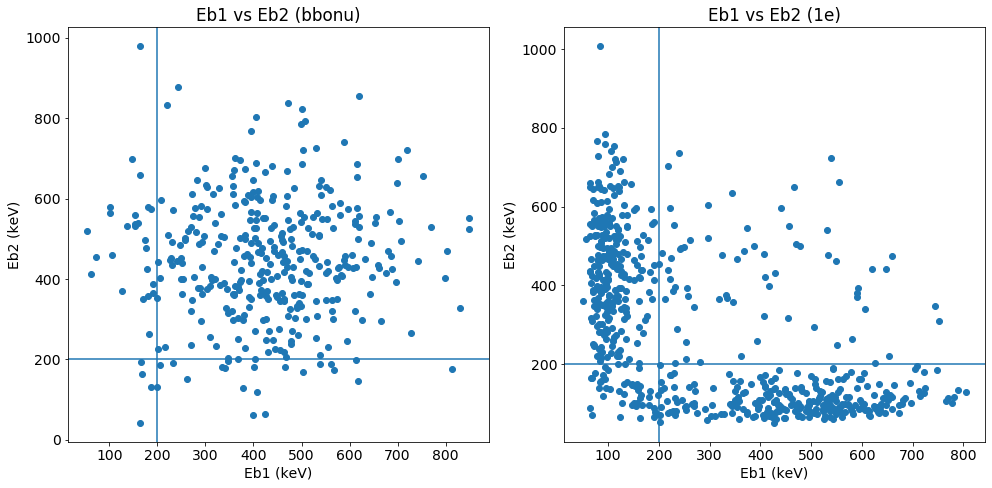

In [186]:
blob_energy(e1tbb, e1t1e, eb_cut=(200,200), figsize=(14,7))

In [187]:
fbb, f1e = select_topology_and_energy(gtbb,gt1e, energy_range=(2400, 2500))

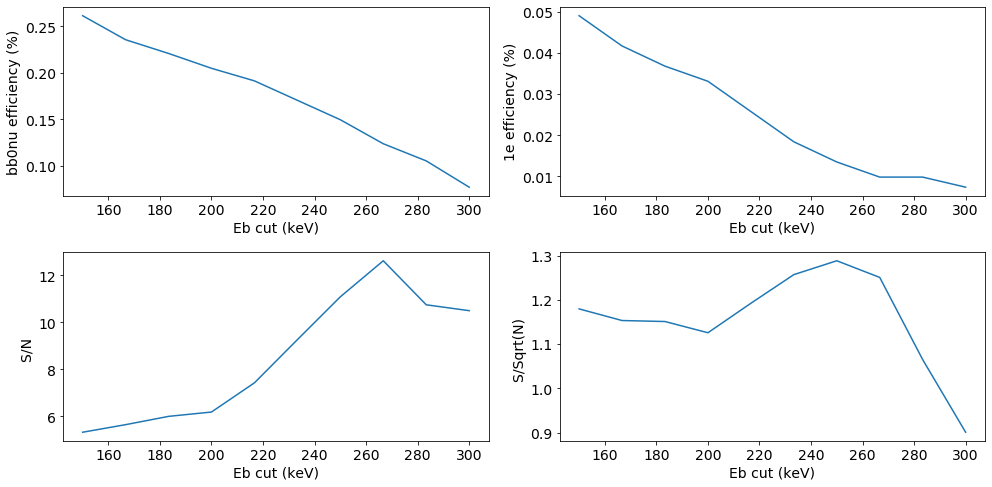

In [188]:
select_blobs_eff_energy(rbb, fbb, f1e, figsize=(14,7))

In [193]:
selection_efficiency(rbb, gtbb, energy_range=(2400, 2500), eb_cut=(240., 240.))

Selection efficiency:
- single track topology  = 0.6588957055214724
- energy cut             = 0.6927374301675978
- 2-blob cut             = 0.3521505376344086
- total efficiency       = 0.1607361963190184


In [194]:
selection_efficiency(r1e, gt1e, energy_range=(2400, 2500), eb_cut=(240., 240.))

Selection efficiency:
- single track topology  = 0.6548018804566823
- energy cut             = 0.6492307692307693
- 2-blob cut             = 0.020537124802527645
- total efficiency       = 0.008730691739422432
